# Apprentissage par renforcement : Upper confidence bound

ICI : T_id est le pas (temps)

Les actions sont : 'rating', 'food_rating' et 'service_rating'

Vous pouvez utiliser le format que vous préférez : 
- DataFrame de pandas (df_data) 
- un tableau numpy (np_data), alors vous allez faire : my_data = np_data
- un dictionnaire (in_data), vous allez faire : my_data = in_data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

# DataFrame
df_data_initial = pd.read_csv("rating_final_user.csv")
df_data = df_data_initial.loc[:, ["T_ID", "rating", "food_rating", "service_rating"]]

# Dictionnaire
in_data = df_data_initial.to_dict()

# Tableau numpy
np_data = df_data_initial.loc[:, ["T_ID", "rating", "food_rating", "service_rating"]].to_numpy()

In [2]:
# 
df_data.head(5)

,T_ID,rating,food_rating,service_rating
0,1,1,1,2
1,2,1,1,1
2,3,1,1,1
3,4,1,1,1
4,5,1,1,1


In [3]:
print(np_data)

[[   1    1    1    2]
 [   2    1    1    1]
 [   3    1    1    1]
 ...
 [1159    2    2    2]
 [1160    2    2    1]
 [1161    1    2    1]]


In [4]:
print(in_data)

{'T_ID': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 98, 98: 99, 99: 100, 100: 101, 101: 102, 102: 103, 103: 104, 104: 105, 105: 106, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114, 114: 115, 115: 116, 116: 117, 117: 118, 118: 119, 119: 120, 120: 121

<h3>Faire UCB avec initialisation à zéro. </h3>

# Explication reinforcement

## 1. Exam UCB

Pour poser le problème nous avons 3 bras : "rating", "food_rating", "service_rating".

Nous savons qu'une bonne note pour un bras est 2, la moins bonne est 0. Nous ne pouvons donc ici distinguer ou discriminer un service ou la nourriture proposée donc nous n'avons pas besoin de méthode d'exploration basé sur l'aléatoire mais basé sur la réponse donnée pour un bras contenu dans notre jeu de donnée. C'est ainsi que nous pourrons attribué la récompense à chaque pas.

L'algorithme UCB suppose donc qu'ils ont tous la même valeur moyenne observée. Ensuite, l'algorithme crée une limite de confiance pour chacune des données évalués. Il choisit donc la note égale à la précédente pour chaque action possible.

Explication de l'algorithme UCB Objectif:  optimiser le rendement moyen au fur et à mesure des itérations, en choisissant les bras les plus prometteurs mais aussi en essayant les bras à qui on n’a pas encore donné une chance.  Explication de la formule:  
µi : représente la moyenne de retour de récompense actuelle du bras i 
t : représente le nombre d’essais global effectué (nombre d’itérations) 
ti : représente le nombre de tirages du bras i

Ensuite, deux choses peuvent se produire : on note la nourriture ou ... puis donne une récompense qui corresond forcément à une note attribuée dans notre jeu de donnée. 

Plus il y a d'avis plus la moyenne observée augmentera et la limite de confiance augmentera également. La fiabilité de nos test ne peut pas diminuer en sachant que l'on a une note à chaque fois.
En exploitant le meilleur échantillon, nous diminuons la limite de confiance. Au fur et à mesure que nous ajoutons de plus en plus d'échantillons, la probabilité que d'autres bras obtiennent de bons résultats augmente également.

## L'algorithme

In [5]:
# pour chaque pas :

def ucb(my_data, c: int, rand_nb: int = 50) -> tuple[dict, dict]:
    out_reward = {"rating":[], "food_rating":[], "service_rating":[]}
    Qta = {"rating":[], "food_rating":[], "service_rating":[]}
    out_UCB_reward = {"rating":0, "food_rating":0, "service_rating":0}

    for i in range(my_data.shape[0]):
        max_upper_bound = 0
        QTA = 0
        if i < rand_nb: # exploration : on choisit une action aléatoire:
            # liste des actions : 
            actions_list = out_reward.keys()
            number_actions = len(actions_list)
            
            # on choisit au hasard un index des clés de out_reward :
            index = random.randint(0, number_actions - 1)
            
            action = list(out_reward.keys())[index]
        else: # exploitation : on choisit la meilleure action pour l'état présent:
            action = ""
            max_action_value = 0
            
            for current_action in Qta.keys():
                # Using the best UCB to select action
                qa = out_UCB_reward[current_action]
                if qa >= max_action_value:
                    max_action_value = qa
                    action = current_action

        # New UCB
        # On rajoute la recompense à la liste des recompenses correspondante dans out_reward :
        reward = my_data.loc[i, action]
        # On calcule Qt(a) pour cette action, selon la règle de la mise à jour incrémentale
        N = len(Qta[action]) # nombre de fois que l'action a été prise
        
        if N == 0: 
            # cas particulier du premier élément :
            #la valeur de l'action est égale à la recompense courrante
            QTA = reward
        else:
            QTA_precedent = Qta[action][-1]
            QTA = QTA_precedent + (1/N) * (reward - QTA_precedent)

        # Ensuite on la met dans Qta
        Qta[action].append(QTA)
        
        # on recupere la recompense
        ucb = np.argmax(QTA + c * np.sqrt(math.log(i + 1) / len(my_data)))

        # On calcule, pour chaque action de out_reward, le UCB, selon la formule du cours 1
        # On le rajoute en out_UCB_reward
        out_UCB_reward[action] = ucb
        out_reward[action].append(reward)

        # Reste
        for act in Qta.keys():
            if act == action:
                continue
            else:
                reward = my_data.loc[i, act]
                QTA = reward
                if len(Qta[act]) > 0: # cas particulier du premier élément
                    # on récupère la dernière valeur de l'action de l'action:=
                    QTA = Qta[act][-1]
                    QTA = QTA_precedent + (1/N) * (reward - QTA_precedent)
                
                ucb = np.argmax(QTA + c * np.sqrt(math.log(i + 1) / len(my_data)))
                    
                # On la rajoute à la liste, puisqu'elle ne changera pas à ce moment T:
                Qta[act].append(QTA) 
                out_UCB_reward[act] = ucb
                out_reward[act].append(reward)

    return Qta, out_UCB_reward, out_reward



## Fonction d'affichage

In [6]:
# On affiche out_UCB_reward avec matplotlib

def print_ucb_plot(data, out_ucb_reward, qta):

    nombre_pas = data.shape[0] # nombre d'élements dans le DataFrame = nombre steps
    x = range(data.shape[0])

    # pour chaque clé k dans Q
    plt.title("Valeurs de l'action à chaque moment T")
    for action in qta.keys():
        plt.plot(x,  qta[action])

    plt.show()    



In [7]:
def print_reward_hist(data, any_reward_avg):
    plt.title("Valeurs de l'action pour toutes les actions")
    plt.hist(any_reward_avg)

Tests

In [8]:
my_data = df_data.copy()
Qta, out_UCB_reward, out_reward = ucb(my_data, 1)

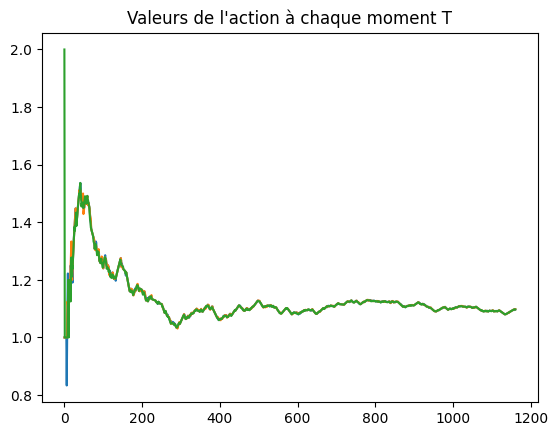

In [9]:
# Test avec comme coefficient 3
print_ucb_plot(my_data, out_UCB_reward, Qta)

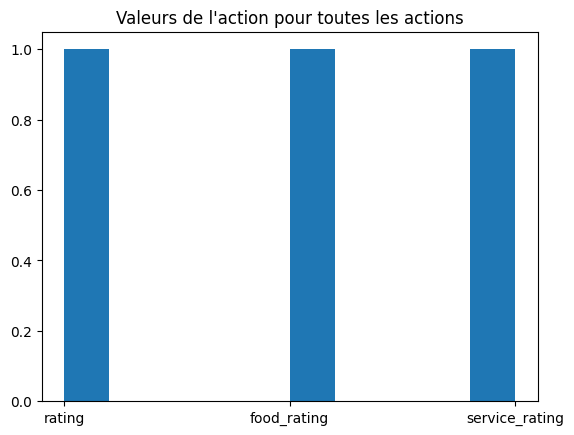

In [10]:
print_reward_hist(my_data, out_reward)

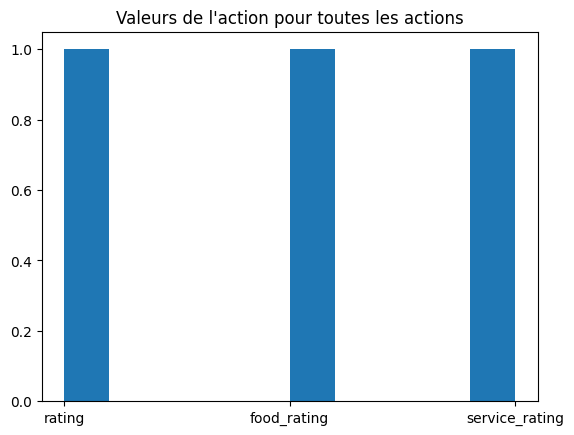

In [11]:
print_reward_hist(my_data, out_UCB_reward)

<h3>Faire UCB avec une autre initialisation </h3>

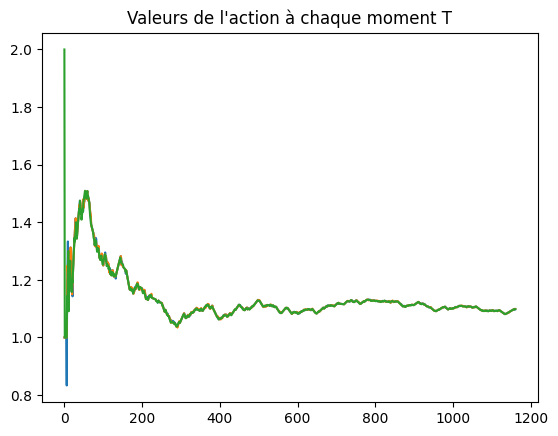

In [12]:
my_data = df_data.copy()
Qta5, out_UCB_reward5, out_reward5 = ucb(my_data, 50)
print_ucb_plot(my_data, out_UCB_reward5, Qta5)

On en déduit que peut importe le coefficient sachant que les données sont connues à l'avance l'apprentissage est le même.